<a href="https://colab.research.google.com/github/lailyafiah/Artificial-Intelligence-Expert/blob/main/Tugas_DataScience.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from datetime import datetime
from statsmodels.tsa.stattools import adfuller
plt.rcParams['figure.figsize'] = 15, 6            #agar semua plot ukurannya sama
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
import warnings
from sklearn.metrics import mean_squared_error
from math import sqrt
from statsmodels.tsa.seasonal import seasonal_decompose

In [ ]:
!wget https://raw.githubusercontent.com/ejgao/Time-Series-Datasets/master/monthly-beer-production-in-austr.csv

--2022-04-17 11:43:48--  https://raw.githubusercontent.com/ejgao/Time-Series-Datasets/master/monthly-beer-production-in-austr.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6426 (6.3K) [text/plain]
Saving to: ‘monthly-beer-production-in-austr.csv’

monthly-beer-produc 100%[===================>]   6.28K  --.-KB/s    in 0s      

2022-04-17 11:43:48 (47.0 MB/s) - ‘monthly-beer-production-in-austr.csv’ saved [6426/6426]



In [ ]:
#Load data
data = pd.read_csv('monthly-beer-production-in-austr.csv')
print(data.head())
print('\n Data Types:')
print(data.dtypes)

     Month  Monthly beer production
0  1956-01                     93.2
1  1956-02                     96.0
2  1956-03                     95.2
3  1956-04                     77.1
4  1956-05                     70.9

 Data Types:
Month                       object
Monthly beer production    float64
dtype: object


In [ ]:
len(data) 

476

In [ ]:
data

,Month,Monthly beer production
0,1956-01,93.2
1,1956-02,96.0
2,1956-03,95.2
3,1956-04,77.1
4,1956-05,70.9
...,...,...
471,1995-04,127.0
472,1995-05,151.0
473,1995-06,130.0
474,1995-07,119.0


In [ ]:
#Mengubah tanggal menjadi index
con=data['Month']
data['Month']=pd.to_datetime(data['Month'])
data.set_index('Month', inplace=True)
#check datatype of index
data.index

DatetimeIndex(['1956-01-01', '1956-02-01', '1956-03-01', '1956-04-01',
               '1956-05-01', '1956-06-01', '1956-07-01', '1956-08-01',
               '1956-09-01', '1956-10-01',
               ...
               '1994-11-01', '1994-12-01', '1995-01-01', '1995-02-01',
               '1995-03-01', '1995-04-01', '1995-05-01', '1995-06-01',
               '1995-07-01', '1995-08-01'],
              dtype='datetime64[ns]', name='Month', length=476, freq=None)

In [ ]:
data

,Monthly beer production
Month,
1956-01-01,93.2
1956-02-01,96.0
1956-03-01,95.2
1956-04-01,77.1
1956-05-01,70.9
...,...
1995-04-01,127.0
1995-05-01,151.0
1995-06-01,130.0


In [ ]:
ts = data['Monthly beer production']
ts.head(10)

Month
1956-01-01     93.2
1956-02-01     96.0
1956-03-01     95.2
1956-04-01     77.1
1956-05-01     70.9
1956-06-01     64.8
1956-07-01     70.1
1956-08-01     77.3
1956-09-01     79.5
1956-10-01    100.6
Name: Monthly beer production, dtype: float64

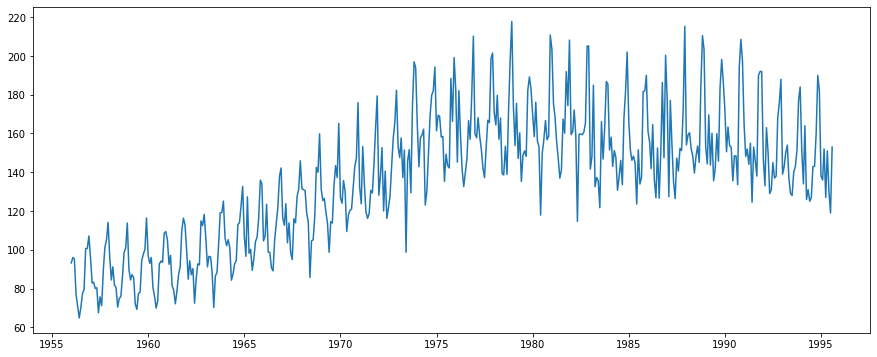

In [ ]:
plt.plot(ts)

In [ ]:
#Membuat fungsi untuk uji stasioneritas
def test_stationarity(timeseries):
    
    #Determing rolling statistics
    rolmean = timeseries.rolling( window=12).mean()
    rolstd = timeseries.rolling( window=12).std()

    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()
    

    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

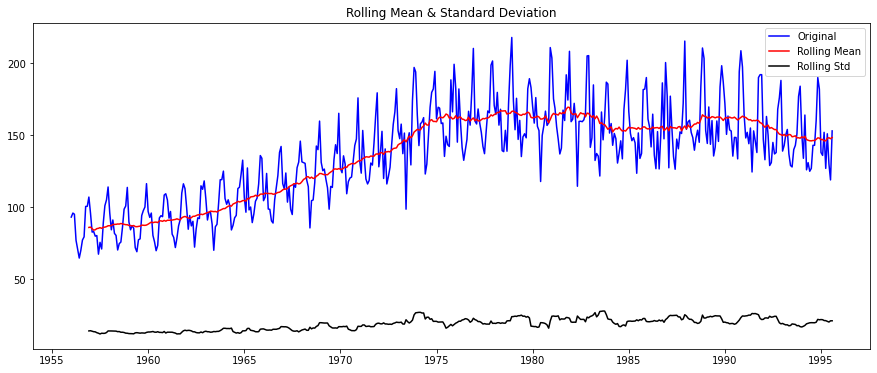

Results of Dickey-Fuller Test:
Test Statistic                  -2.282661
p-value                          0.177621
#Lags Used                      17.000000
Number of Observations Used    458.000000
Critical Value (1%)             -3.444709
Critical Value (5%)             -2.867871
Critical Value (10%)            -2.570142
dtype: float64


In [ ]:
#Menguji data
test_stationarity(ts)

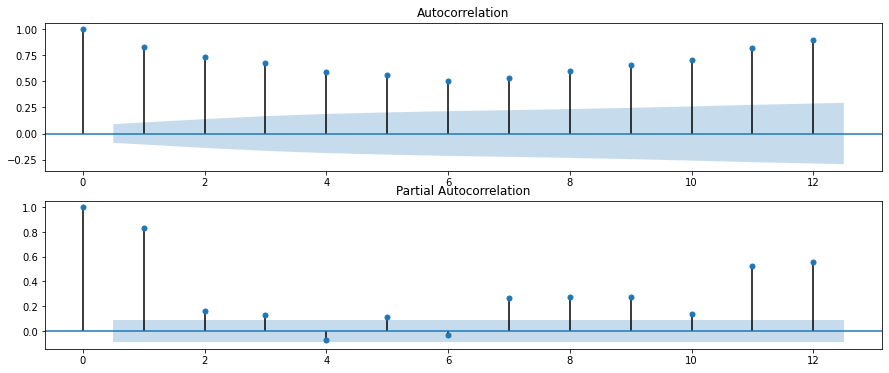

In [ ]:
plt.figure()
plt.subplot(211)
plot_acf(ts, ax=plt.gca(), lags=12)
plt.subplot(212)
plot_pacf(ts, ax=plt.gca(), lags=12)
plt.show()

In [ ]:
def evaluate_arima_model(X, arima_order):
	# prepare training dataset
	X = X.astype('float32')
	train_size = int(len(X) * 0.7)               #data trainingnya 70%
	train, test = X[0:train_size], X[train_size:]
	history = [x for x in train]
	# make predictions
	predictions = list()
	for t in range(len(test)):
		model = ARIMA(history, order=arima_order)
		model_fit = model.fit()
		yhat = model_fit.forecast()[0]
		predictions.append(yhat)
		history.append(test[t])
	# calculate out of sample error
	rmse = sqrt(mean_squared_error(test, predictions))
	return rmse

# evaluate combinations of p, d and q values for an ARIMA model
# evaluate combinations of p, d and q values for an ARIMA model
def evaluate_models(dataset, p_values, d_values, q_values):
	dataset = dataset.astype('float32')
	best_score, best_cfg = float("inf"), None
	for p in p_values:
		for d in d_values:
			for q in q_values:
				order = (p,d,q)
				try:
					rmse = evaluate_arima_model(dataset, order)
					if rmse < best_score:
						best_score, best_cfg = rmse, order
					print('ARIMA%s RMSE=%.3f' % (order,rmse))
				except:
					continue
	print('Best ARIMA%s RMSE=%.3f' % (best_cfg, best_score))

In [ ]:
p_values = range(0, 3)
d_values = range(0, 2)
q_values = range(0, 3)
warnings.filterwarnings("ignore")
evaluate_models(ts.values, p_values, d_values, q_values)

ARIMA(0, 0, 0) RMSE=31.010
ARIMA(0, 0, 1) RMSE=23.952
ARIMA(0, 0, 2) RMSE=23.764
ARIMA(0, 1, 0) RMSE=22.716
ARIMA(0, 1, 1) RMSE=21.894
ARIMA(0, 1, 2) RMSE=19.842
ARIMA(1, 0, 0) RMSE=21.469
ARIMA(1, 0, 1) RMSE=21.270
ARIMA(1, 1, 0) RMSE=22.214
ARIMA(2, 0, 0) RMSE=21.367
ARIMA(2, 0, 1) RMSE=19.708
ARIMA(2, 1, 0) RMSE=21.736
ARIMA(2, 1, 1) RMSE=19.933
Best ARIMA(2, 0, 1) RMSE=19.708


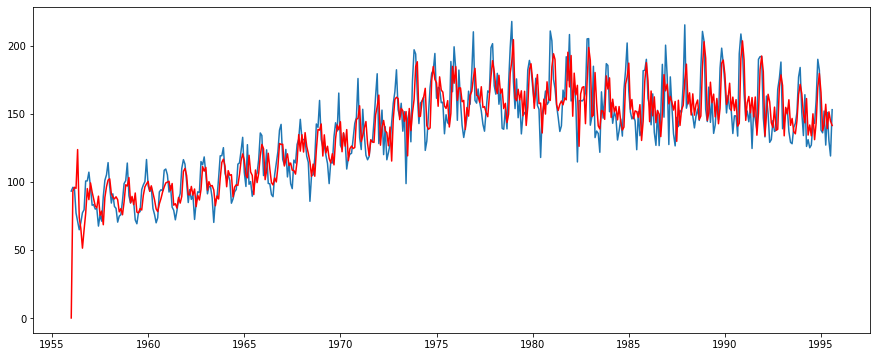

In [ ]:
#SARIMA + trend untuk data asli
model_sarima_trend = SARIMAX(ts, order=(1,1,1), seasonal_order=(1,1,1,4), trend='t')
results_SARIMA_t = model_sarima_trend.fit(disp=-1)
predictions_SARIMA_diff_t = pd.Series(results_SARIMA_t.fittedvalues,copy=True)
plt.plot(ts)             
plt.plot(predictions_SARIMA_diff_t, color='red')

In [ ]:
print(results_SARIMA_t.summary())

                                 Statespace Model Results                                
Dep. Variable:           Monthly beer production   No. Observations:                  476
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 4)   Log Likelihood               -1999.914
Date:                           Sun, 17 Apr 2022   AIC                           4011.828
Time:                                   04:06:45   BIC                           4036.757
Sample:                               01-01-1956   HQIC                          4021.635
                                    - 08-01-1995                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
drift        4.51e-05   4.57e-05      0.987      0.324   -4.45e-05       0.000
ar.L1          0.3507      0.168      2.089

In [ ]:
#prediksi dengan SARIMA+trend
pred_2 = results_SARIMA_t.predict(start=120,end=180)
print(pred_2)

1966-01-01    124.353056
1966-02-01    101.610877
1966-03-01    108.328558
1966-04-01    120.988813
1966-05-01    109.512106
                 ...    
1970-09-01    124.477374
1970-10-01    125.208830
1970-11-01    145.947100
1970-12-01    146.668255
1971-01-01    155.867463
Freq: MS, Length: 61, dtype: float64


Perbandingan dengan menggunakan Deep Learning

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_theme(style="whitegrid")
import warnings
warnings.filterwarnings("ignore")

In [ ]:
data = pd.read_csv('monthly-beer-production-in-austr.csv')
data.head(10)

,Month,Monthly beer production
0,1956-01,93.2
1,1956-02,96.0
2,1956-03,95.2
3,1956-04,77.1
4,1956-05,70.9
5,1956-06,64.8
6,1956-07,70.1
7,1956-08,77.3
8,1956-09,79.5
9,1956-10,100.6


Membuat Pendeketan Statistika dengan Deelp Learning menggunakan LSTM

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 476 entries, 0 to 475
Data columns (total 2 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Month                    476 non-null    object 
 1   Monthly beer production  476 non-null    float64
dtypes: float64(1), object(1)
memory usage: 7.6+ KB


In [ ]:
#Mengubah tanggal menjadi index
con=data['Month']
data['Month']=pd.to_datetime(data['Month'])
data.set_index('Month', inplace=True)
#check datatype of index
data.index

DatetimeIndex(['1956-01-01', '1956-02-01', '1956-03-01', '1956-04-01',
               '1956-05-01', '1956-06-01', '1956-07-01', '1956-08-01',
               '1956-09-01', '1956-10-01',
               ...
               '1994-11-01', '1994-12-01', '1995-01-01', '1995-02-01',
               '1995-03-01', '1995-04-01', '1995-05-01', '1995-06-01',
               '1995-07-01', '1995-08-01'],
              dtype='datetime64[ns]', name='Month', length=476, freq=None)

In [ ]:
data

,Monthly beer production
Month,
1956-01-01,93.2
1956-02-01,96.0
1956-03-01,95.2
1956-04-01,77.1
1956-05-01,70.9
...,...
1995-04-01,127.0
1995-05-01,151.0
1995-06-01,130.0


In [ ]:
df1 = df[-24*365:].reset_index(drop=True)
df1.head()

,Month,Monthly beer production
0,1956-01,93.2
1,1956-02,96.0
2,1956-03,95.2
3,1956-04,77.1
4,1956-05,70.9


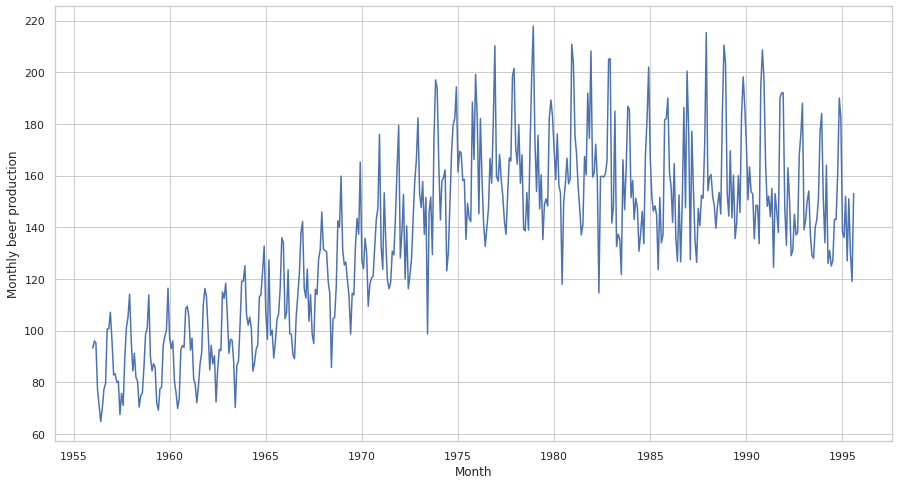

In [ ]:
plt.figure(figsize=(15,8))
sns.lineplot(data=data, x='Month', y='Monthly beer production')

In [ ]:
data.describe()

,Monthly beer production
count,476.000000
mean,136.395378
std,33.738725
min,64.800000
25%,112.900000
50%,139.150000
75%,158.825000
max,217.800000


In [ ]:
# split data
train_size = int(len(data) * 0.8) # Menentukan banyaknya data train yaitu sebesar 70% data
train = data[:train_size]
test =data[train_size:].reset_index(drop=True)

In [ ]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(train[['Monthly beer production']])

train['scaled'] = scaler.transform(train[['Monthly beer production']])
test['scaled'] = scaler.transform(test[['Monthly beer production']])

In [ ]:
train.head()

,Monthly beer production,scaled
Month,,
1956-01-01,93.2,0.185621
1956-02-01,96.0,0.203922
1956-03-01,95.2,0.198693
1956-04-01,77.1,0.080392
1956-05-01,70.9,0.039869


In [ ]:
def sliding_window(data, window_size):
    sub_seq, next_values = [], []
    for i in range(len(data)-window_size):
        sub_seq.append(data[i:i+window_size])
        next_values.append(data[i+window_size])
    X = np.stack(sub_seq)
    y = np.array(next_values)
    return X,y

In [ ]:
window_size = 12

X_train, y_train = sliding_window(train[['scaled']].values, window_size)
X_test, y_test = sliding_window(test[['scaled']].values, window_size)

In [ ]:
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(368, 12, 1) (368, 1)
(84, 12, 1) (84, 1)


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM #, RNN, GRU

In [ ]:
def create_model(LSTM_unit=64, dropout=0.2): #jika ingin menggunakan RNN atau GRU ganti LSTM dengan GRU/RNN
    # create model
    model = Sequential()
    model.add(LSTM(units=LSTM_unit, input_shape=(window_size, 1)))
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(dropout))
    model.add(Dense(1))
    # Compile model
    model.compile(loss='mse', optimizer='adam', metrics=['mae'])
    return model

In [ ]:
LSTM_unit = [16,32,64,128]
dropout = [0.1,0.2]

In [ ]:
from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasRegressor
from keras.callbacks import EarlyStopping
# Early Stopping
es = EarlyStopping(monitor = 'val_loss', mode = "min", patience = 5, verbose = 0)

# create model
model = KerasRegressor(build_fn=create_model, epochs=50, validation_split=0.1, batch_size=32, callbacks=[es], verbose=1)

# define the grid search parameters
LSTM_unit = [16,32,64,128]
dropout=[0.1,0.2]
param_grid = dict(LSTM_unit=LSTM_unit, dropout=dropout)

In [ ]:
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=5)

In [ ]:
grid_result = grid.fit(X_train, y_train)

Epoch 1/50
11/11 [==============================] - 3s 64ms/step - loss: 0.1532 - mae: 0.3290 - val_loss: 0.0805 - val_mae: 0.2443
Epoch 2/50
11/11 [==============================] - 0s 9ms/step - loss: 0.0267 - mae: 0.1306 - val_loss: 0.0291 - val_mae: 0.1529
Epoch 3/50
11/11 [==============================] - 0s 10ms/step - loss: 0.0237 - mae: 0.1242 - val_loss: 0.0298 - val_mae: 0.1283
Epoch 4/50
11/11 [==============================] - 0s 10ms/step - loss: 0.0233 - mae: 0.1166 - val_loss: 0.0225 - val_mae: 0.1275
Epoch 5/50
11/11 [==============================] - 0s 10ms/step - loss: 0.0198 - mae: 0.1158 - val_loss: 0.0241 - val_mae: 0.1178
Epoch 6/50
11/11 [==============================] - 0s 11ms/step - loss: 0.0195 - mae: 0.1074 - val_loss: 0.0222 - val_mae: 0.1196
Epoch 7/50
11/11 [==============================] - 0s 10ms/step - loss: 0.0205 - mae: 0.1157 - val_loss: 0.0223 - val_mae: 0.1185
Epoch 8/50
11/11 [==============================] - 0s 11ms/step - loss: 0.0200 - ma

In [ ]:
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))
    
# Mengambil model terbaik
best_model = grid_result.best_estimator_.model

Best: -0.008128 using {'LSTM_unit': 64, 'dropout': 0.1}
-0.017666 (0.003545) with: {'LSTM_unit': 16, 'dropout': 0.1}
-0.018927 (0.004144) with: {'LSTM_unit': 16, 'dropout': 0.2}
-0.015763 (0.005586) with: {'LSTM_unit': 32, 'dropout': 0.1}
-0.015777 (0.006578) with: {'LSTM_unit': 32, 'dropout': 0.2}
-0.008128 (0.002941) with: {'LSTM_unit': 64, 'dropout': 0.1}
-0.008952 (0.002186) with: {'LSTM_unit': 64, 'dropout': 0.2}
-0.010658 (0.003785) with: {'LSTM_unit': 128, 'dropout': 0.1}
-0.012656 (0.007541) with: {'LSTM_unit': 128, 'dropout': 0.2}


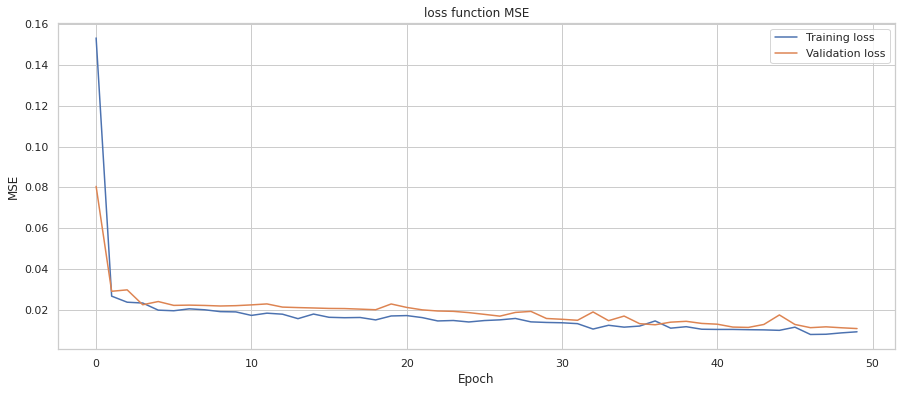

In [ ]:
history = best_model.history
# grafik loss function MSE

plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.title('loss function MSE')
plt.ylabel('MSE')
plt.xlabel('Epoch')
plt.legend()

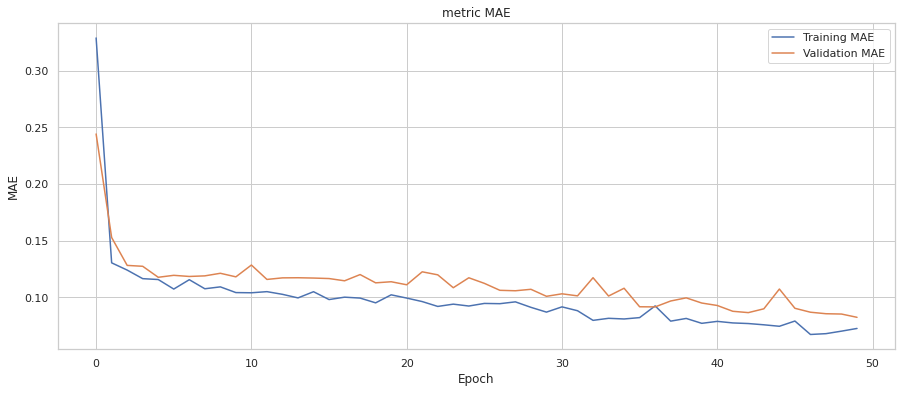

In [ ]:
# grafik metric MAE

plt.plot(history.history['mae'], label='Training MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.title('metric MAE')
plt.ylabel('MAE')
plt.xlabel('Epoch')
plt.legend()

In [ ]:
# Prediksi data train
predict_train = scaler.inverse_transform(best_model.predict(X_train))
true_train = scaler.inverse_transform(y_train)

# Prediksi data test
predict_test = scaler.inverse_transform(best_model.predict(X_test))
true_test = scaler.inverse_transform(y_test)

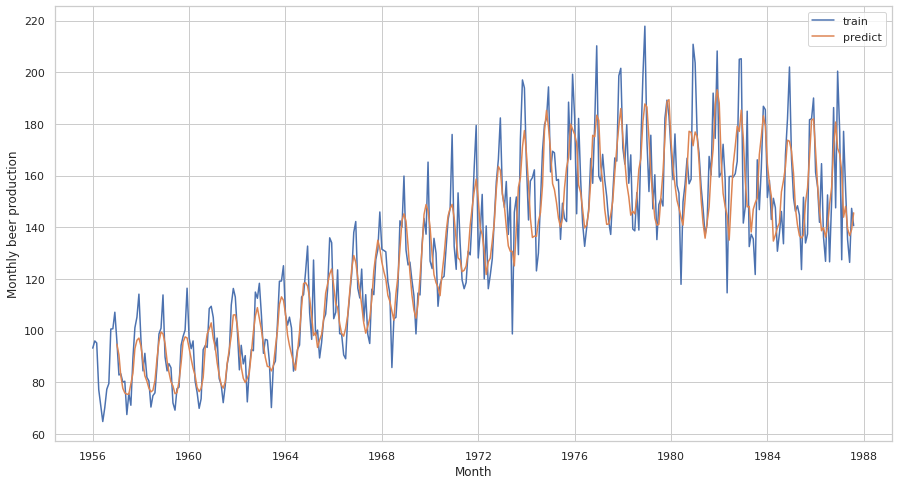

In [ ]:
train['predict'] = np.nan
train['predict'][-len(predict_train):] = predict_train[:,0]

plt.figure(figsize=(15,8))
sns.lineplot(data=train, x='Month', y='Monthly beer production', label = 'train')
sns.lineplot(data=train, x='Month', y='predict', label = 'predict')